In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
#import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df1 = pd.read_csv('/content/drive/MyDrive/feb11-nn/recon650k.csv')
df2 = pd.read_csv('/content/drive/MyDrive/feb11-nn/labels650k.csv')

X = df1.values
y = df2.values

n = 650000

X = np.reshape(X, (n,13,21,1))

In [ ]:
path = os.getcwd()
print(path)
os.mkdir('/content/drive/MyDrive/feb11-nn/image-x')
os.chdir('/content/drive/MyDrive/feb11-nn/image-x')
print(os.getcwd())

/content
/content/drive/MyDrive/feb11-nn/image-x


In [ ]:
df2['cotAlpha-revised']=df2['cotAlpha']*50
df2['x-midplane']=df2['x-entry']+df2['cotAlpha-revised']


In [ ]:
df2.head()

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,cotAlpha,cotBeta,x-midplane,cotAlpha-revised
0,-168.364151,-2.262124,0.0,0.964984,0.025727,0.261045,25841,3.696619,0.098554,16.466817,184.830968
1,-127.467667,15.197241,0.0,0.916642,-0.080666,0.391486,15311,2.341443,-0.206051,-10.395537,117.072130
2,-369.492645,-0.128008,0.0,0.991058,-0.002360,0.133412,87317,7.428552,-0.017690,1.934963,371.427608
3,-365.951111,-4.567823,0.0,0.991881,0.005613,0.127042,84117,7.807505,0.044182,24.424119,390.375230
4,-200.628601,14.304100,0.0,0.967751,-0.047386,0.247411,32069,3.911512,-0.191527,-5.053020,195.575581


In [ ]:
#note: labels.csv has 11 columns; you need to drop the column you don't want, and then adjust number of outputs in your NN

#df2.head()
df2.drop('cotAlpha-revised', axis=1, inplace=True)
df2.drop('x-entry', axis=1, inplace=True)
df2.drop('y-entry', axis=1, inplace=True)
df2.drop('z-entry', axis=1, inplace=True)
df2.drop('n_x', axis=1, inplace=True)
df2.drop('n_y', axis=1, inplace=True)
df2.drop('n_z', axis=1, inplace=True)
df2.drop('number_eh_pairs', axis=1, inplace=True)
df2.drop('cotAlpha', axis=1, inplace=True)
df2.drop('cotBeta', axis=1, inplace=True)

print(df2.head())
#df2.shape

#reset y since you dropped columns
y = df2.values

   x-midplane
0   16.466817
1  -10.395537
2    1.934963
3   24.424119
4   -5.053020


In [ ]:
df2.head()

,x-midplane
0,16.466817
1,-10.395537
2,1.934963
3,24.424119
4,-5.053020


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


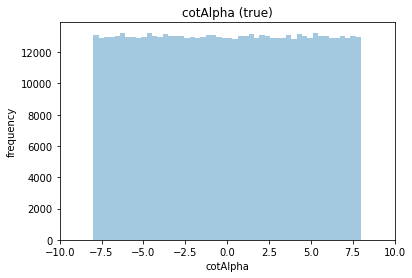

In [ ]:
#histo. of true cotAlpha values
df_true_cotAlpha = pd.DataFrame(df2, columns=['cotAlpha'])
sns.distplot(df_true_cotAlpha['cotAlpha'], kde=False, bins=50)
plt.xlabel('cotAlpha')
plt.xlim([-10,10])
plt.ylabel('frequency')
plt.title("cotAlpha (true)")
plt.savefig('cotAlpha-true.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


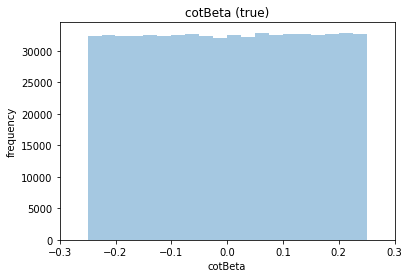

In [ ]:
df_true_cotBeta = pd.DataFrame(df2, columns=['cotBeta'])
sns.distplot(df_true_cotBeta['cotBeta'], kde=False, bins=20)
plt.xlim([-0.3,0.3])
plt.xlabel('cotBeta')
plt.ylabel('frequency')
plt.title("cotBeta (true)")
plt.savefig('cotBeta-true.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


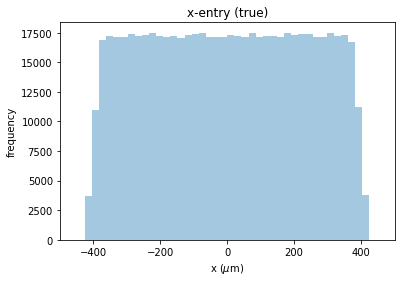

In [ ]:
df_true_x = pd.DataFrame(df2, columns=['x-entry'])
sns.distplot(df_true_x['x-entry'], kde=False, bins=40)
plt.xlim([-500,500])
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('frequency')
plt.title("x-entry (true)")
plt.savefig('x-entry-true.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


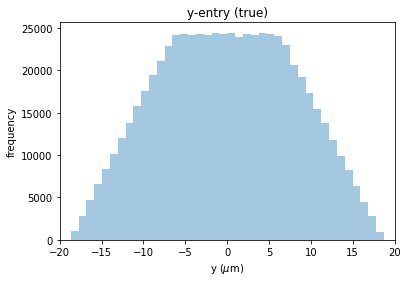

In [ ]:
df_true_y = pd.DataFrame(df2, columns=['y-entry'])
sns.distplot(df_true_y['y-entry'], kde=False, bins=40)
plt.xlabel(r'y ($\mu$m)')
plt.xlim([-20,20])
plt.ylabel('frequency')
plt.title("y-entry (true)")
plt.savefig('y-entry-true.png')

In [ ]:
#https://keras.io/api/callbacks/#csvlogger
#from https://keras.io/guides/writing_your_own_callbacks/
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

   # def on_predict_batch_begin(self, batch, logs=None):
    #    keys = list(logs.keys())
     #   print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

#    def on_predict_batch_end(self, batch, logs=None):
 #       keys = list(logs.keys())
  #      print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#scale input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#make a simple model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', input_shape=(13, 21, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='linear'))
model.summary()


(650000, 13, 21, 1) (650000, 1)
(520000, 13, 21, 1) (130000, 13, 21, 1) (520000, 1) (130000, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 10, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 5, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 2, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)        

In [ ]:
checkpoint_path = "cp.ckpt"

# Create a callback that saves the model's weights 
# currently, model weights are saved for each training
# to do - update for early stopping
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#patience: Number of epochs with no improvement after which training will be stopped
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

csv_logger = CSVLogger('log.csv', append=True, separator=';')

batch_size = 64
epochs = 200 
     
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer='adam',
              metrics=['mean_squared_error'])

history = model.fit(
          X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[cp_callback, csv_logger, earlyStop_callback],
          )
          
res = model.evaluate(
    X_test, y_test, batch_size=batch_size,
) 

predictions = model.predict(X_test, batch_size=batch_size, callbacks=[CustomCallback()])

Epoch 1/200
8120/8125 [============================>.] - ETA: 0s - loss: 1326.9923 - mean_squared_error: 1326.9923
Epoch 00001: saving model to cp.ckpt
8125/8125 [==============================] - 42s 4ms/step - loss: 1326.3900 - mean_squared_error: 1326.3900 - val_loss: 207.6833 - val_mean_squared_error: 207.6833
Epoch 2/200
8124/8125 [============================>.] - ETA: 0s - loss: 376.1361 - mean_squared_error: 376.1361
Epoch 00002: saving model to cp.ckpt
8125/8125 [==============================] - 33s 4ms/step - loss: 376.1333 - mean_squared_error: 376.1333 - val_loss: 165.1845 - val_mean_squared_error: 165.1845
Epoch 3/200
8124/8125 [============================>.] - ETA: 0s - loss: 340.1420 - mean_squared_error: 340.1420
Epoch 00003: saving model to cp.ckpt
8125/8125 [==============================] - 34s 4ms/step - loss: 340.1435 - mean_squared_error: 340.1435 - val_loss: 164.8034 - val_mean_squared_error: 164.8034
Epoch 4/200
8125/8125 [==============================] - ETA

In [ ]:
#save model                                                      
# serialize model to JSON                                                                                                                                                          
model_json = model.to_json()                                                                                                              
with open("model.json", "w") as json_file:                                                    
  json_file.write(model_json)                                 
                     
#save full model in hd5 format                    
   
model.save('my_model.h5')

#alt. methods
#You can save History attribute of tf.keras.callbacks.History in .txt form
#with open("/content/drive/MyDrive/NN-jan28/result_model.txt",'w') a   s f:
#    for k in history.history.keys():
#        print(k,file=f)
#        for i in history.history[k]:
#            print(i,file=f)
#import pickle
#with open('/content/drive/MyDrive/NN-jan28/trainHistoryDict', 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)

130000
           x-entry
0       309.980255
1      -150.807404
2      -396.349976
3         0.030913
4        78.889336
...            ...
129995  228.242599
129996  393.858551
129997  180.389740
129998   59.635380
129999 -250.462784

[130000 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


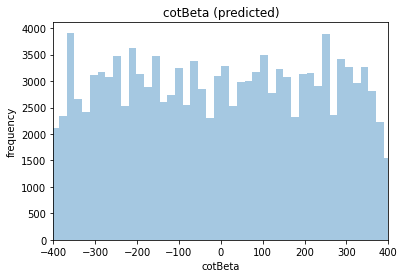

In [ ]:
print(len(predictions))
df_predict = pd.DataFrame(predictions, columns=['x-entry'])
print(df_predict)
df_predict.head()
sns.distplot(df_predict['x-entry'], kde=False, bins=50)
plt.xlim([-400,400])
plt.xlabel('cotBeta')
plt.ylabel('frequency')
plt.title("cotBeta (predicted)")
plt.savefig('x-prediction.png')

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)
#print(X.shape, y.shape)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#df_predict = pd.DataFrame(predictions, columns=['x_entry', 'y_entry', 'z_entry', 'cotAlpha', 'cotBeta'])
print(y_test.shape)
trueLabels = pd.DataFrame(y_test, columns=['x-entry'])


(130000, 1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'cotBeta (predicted)')

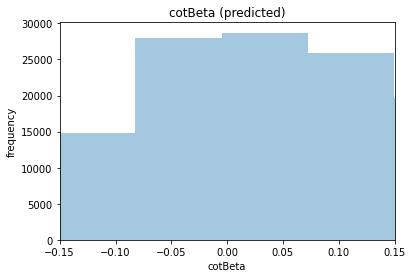

In [ ]:
sns.distplot(df_predict['cotBeta'], kde=False, bins=20)
plt.xlabel('cotBeta')
plt.ylabel('frequency')
plt.xlim([-0.15,0.15])
plt.title("cotBeta (predicted)")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


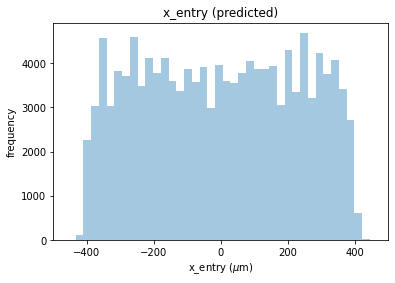

In [ ]:
sns.distplot(df_predict['x-entry'], kde=False, bins=40)
plt.xlabel(r'x_entry ($\mu$m)')
plt.ylabel('frequency')
plt.xlim([-500,500])
plt.title("x_entry (predicted)")
plt.savefig('x-entry-prediction.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


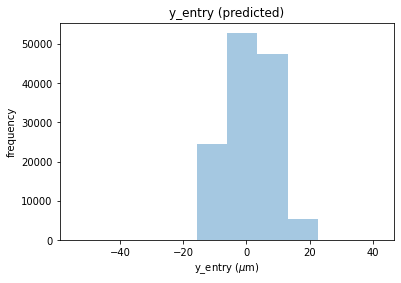

In [ ]:
sns.distplot(df_predict['y_entry'], kde=False, bins=10)
plt.xlabel(r'y_entry ($\mu$m)')
#plt.xlim([-20,20])
plt.ylabel('frequency')
plt.title("y_entry (predicted)")
plt.savefig('y-entry-prediction.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


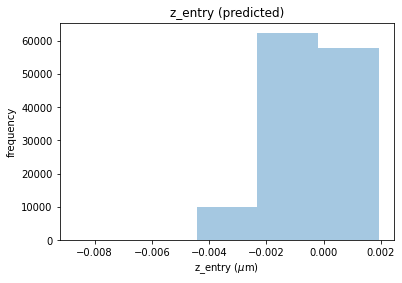

In [ ]:
sns.distplot(df_predict['z_entry'], kde=False, bins=5)
plt.xlabel(r'z_entry ($\mu$m)')
plt.ylabel('frequency')
#plt.xlim(-.5,.5)
plt.title("z_entry (predicted)")
plt.savefig('z-entry-prediction.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


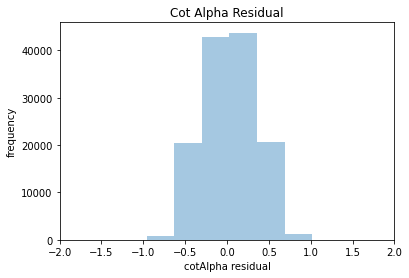

In [ ]:

sns.distplot(trueLabels['cotAlpha']-df_predict['cotAlpha'], kde=False, bins=50)
plt.xlabel('cotAlpha residual')
plt.ylabel('frequency')
plt.xlim([-2,2])
plt.title('Cot Alpha Residual')
plt.savefig('cotAlpha-resolution.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


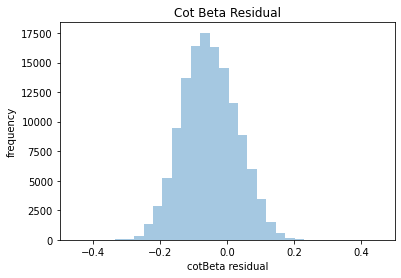

In [ ]:
sns.distplot(trueLabels['cotBeta']-df_predict['cotBeta'], kde=False, bins=50)
plt.xlabel('cotBeta residual')
plt.ylabel('frequency')
plt.xlim([-.5,.5])
plt.title('Cot Beta Residual')
plt.savefig('cotBeta-resolution.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


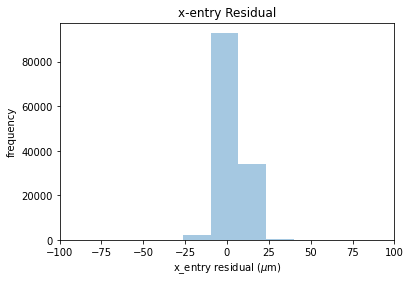

In [ ]:
sns.distplot(trueLabels['x_entry']-df_predict['x_entry'], kde=False, bins=50)
plt.xlabel(r'x_entry residual ($\mu$m)')
plt.ylabel('frequency')
plt.xlim([-100,100])
plt.title('x-entry Residual')
plt.savefig('x-entry-resolution.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


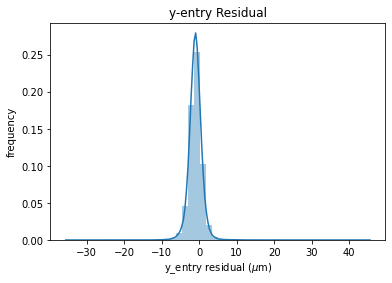

In [ ]:
sns.distplot(trueLabels['y_entry']-df_predict['y_entry'], kde=True, bins=50)
plt.xlabel(r'y_entry residual ($\mu$m)')
plt.ylabel('frequency')
plt.title('y-entry Residual')
plt.savefig('y-entry-resolution.png')

NameError: ignored

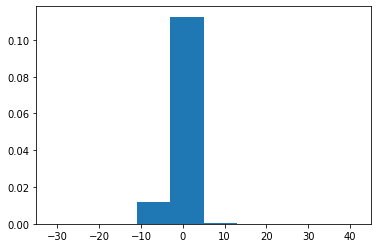

In [ ]:
data = trueLabels['y_entry']-df_predict['y_entry']

plt.figure(1)
plt.hist(data,density=True)
plt.xlim((min(data), max(data)))
mean = np.mean(data)
variance = np.var(data)
sigma = np.sqrt(variance)
x = np.linspace(min(data), max(data), 100)
plt.plot(x, norm.pdf(x, mean, sigma))
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


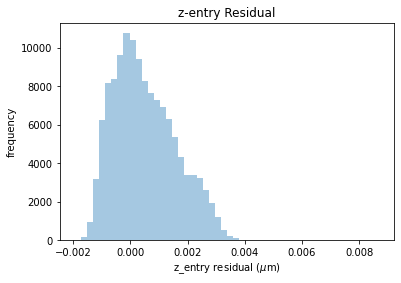

In [ ]:
sns.distplot(trueLabels['z_entry']-df_predict['z_entry'], kde=False, bins=50)
plt.xlabel(r'z_entry residual ($\mu$m)')
plt.ylabel('frequency')
#plt.xlim([-200,200])
plt.title('z-entry Residual')
plt.savefig('z-entry-resolution.png')

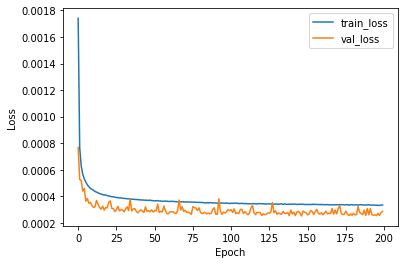

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('loss.png')


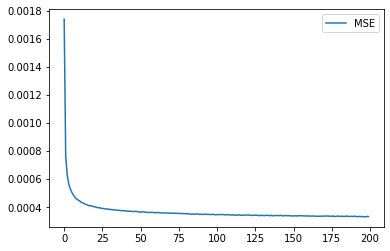

In [ ]:
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.legend(loc='upper right')
plt.savefig('mse.png')

In [ ]:
df_predict.to_csv('predictions.csv')

In [ ]:
trueLabels.to_csv('trueLabels.csv')